In [31]:
# Import Libraries
import itertools
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [32]:
from sklearn import datasets, preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from neupy import algorithms

In [33]:
# Read CSV and set date as the index column. Parsing date in a format to avoid confusion and speed up parsing.
df_org = pd.read_csv('..\\..\\data\\processed\\framework\\d2\\apt_BC_E_DR.csv', index_col=[0], \
                 parse_dates=True, infer_datetime_format="%m/%d/%Y %H:%M:%S")
df_org.head()

,Temperature,Dew Point,Relative Humidity,Month,ActivityLevel,Clothing,SR,SPT_Mi,SPT,SPT_Ma,adjustedSPT,SPT_Random,Occupancy
1998-01-01 00:00:00,15.8,10.4,78.77,1,1.3,0.78,0.0,68,71,75,75.0,73,0
1998-01-01 00:30:00,15.8,10.4,78.81,1,1.3,0.78,0.0,68,71,75,75.0,71,0
1998-01-01 01:00:00,14.0,8.6,76.14,1,1.3,0.78,0.0,68,71,75,75.0,72,1
1998-01-01 01:30:00,14.0,8.6,76.16,1,1.3,0.78,0.0,68,71,75,75.0,68,1
1998-01-01 02:00:00,14.0,8.6,80.40,1,1.3,0.78,0.0,68,71,75,75.0,69,0


In [34]:
df = df_org['2018'].copy()

In [35]:
feature_set = ['Temperature', 'Dew Point', 'Clothing', 'SR', 'Occupancy']
target = 'SPT'

In [45]:
scaler = preprocessing.MinMaxScaler(feature_range = (0, 1))
1100/df.shape[0]

0.06278538812785388

In [37]:
x_train, x_test, y_train, y_test = train_test_split(
   scaler.fit_transform(df[feature_set].astype(int).values),
   scaler.fit_transform(df[target].astype(int).values.reshape(-1, 1)),
    test_size=1100/df.shape[0]
)

In [38]:
nw = algorithms.GRNN(std=0.1, verbose=True)


Main information

[ALGORITHM] GRNN

[OPTION] std = 0.1
[OPTION] verbose = True



In [39]:
nw.train(x_train, y_train)

In [40]:
y_predicted = nw.predict(x_test)

In [41]:
mse = np.mean((y_predicted - y_test) ** 2)
print(mse)

0.04919376653991967


In [12]:
def rmsle(expected, predicted):
    log_expected = np.log1p(expected + 1)
    log_predicted = np.log1p(predicted + 1)
    squared_log_error = np.square(log_expected - log_predicted)
    return np.sqrt(np.mean(squared_log_error))


def scorer(network, X, y):
    result = network.predict(X)
    return rmsle(result, y)

In [13]:
random_search = RandomizedSearchCV(
    algorithms.GRNN(std=0.1, verbose=False),
    param_distributions={'std': np.arange(1e-2, 1, 1e-3)},
    n_iter=100,
    cv=3,
    scoring=scorer,
)

In [14]:
random_search.fit(x_test, y_test)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=GRNN(verbose=False, std=0.1), iid='warn',
                   n_iter=100, n_jobs=None,
                   param_distributions={'std': array([0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
       0.037, 0.038, 0.039, 0.04 , 0.041,...
       0.955, 0.956, 0.957, 0.958, 0.959, 0.96 , 0.961, 0.962, 0.963,
       0.964, 0.965, 0.966, 0.967, 0.968, 0.969, 0.97 , 0.971, 0.972,
       0.973, 0.974, 0.975, 0.976, 0.977, 0.978, 0.979, 0.98 , 0.981,
       0.982, 0.983, 0.984, 0.985, 0.986, 0.987, 0.988, 0.989, 0.99 ,
       0.991, 0.992, 0.993, 0.994, 0.995, 0.996, 0.997, 0.998, 0.999])},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False,
                   scoring=<function scorer at 0x000

In [15]:
import heapq
def report(results, n_top=3):
    ranks = heapq.nlargest(n_top, results['rank_test_score'])

    for i in ranks:
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [24]:
random_search.best_params_['std']

0.9929999999999992

In [16]:
report(random_search.cv_results_)

Mean validation score: 0.096 (std: 0.001)
Parameters: {'std': 0.052999999999999964}

Mean validation score: 0.096 (std: 0.001)
Parameters: {'std': 0.04999999999999997}

Mean validation score: 0.097 (std: 0.001)
Parameters: {'std': 0.04399999999999998}



In [17]:
df_out = pd.DataFrame(data={"Predicted":scaler.inverse_transform(y_predicted.reshape(-1, 1)).reshape(1, -1)[0], \
                   "Actual": scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(1, -1)[0]})

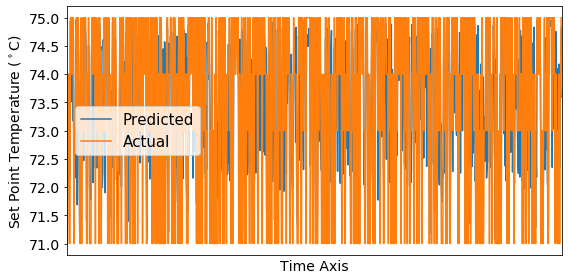

In [28]:
ax = df_out[-1008:].plot(fontsize=14, figsize=(8, 4))
ax.set_xlabel("Time Axis", fontsize=14)
ax.set_ylabel("Set Point Temperature ($^\circ$C)", fontsize=14)

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=15)
plt.tight_layout()

# plt.savefig('../../output/figures/raw/setpointprediction.jpg')

In [43]:
mse = np.mean((df_out['Predicted'] - df_out['Actual']) ** 2)
mse

0.8304543226558002

In [44]:
std = np.std((df_out['Predicted'] - df_out['Actual']) ** 2)
std

1.2276588972725073

In [49]:
(df_out['Predicted'] - df_out['Actual']).abs().mean()

0.7089751427924533